In [20]:
#import libraries 
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Input, add, concatenate, BatchNormalization
from keras.layers import Embedding,SpatialDropout1D, LSTM, Bidirectional, Dot
from keras.layers import Conv1D, GlobalMaxPooling1D,GlobalAveragePooling1D
from keras.initializers import Constant
from keras.optimizers import Adam

import pandas as pd
import numpy as np
import keras 
import nltk
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import helpers
from tqdm import tqdm
import re
from zeugma.embeddings import EmbeddingTransformer
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

stop=set(stopwords.words('english'))

### Data preprocessing + GloVE

https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#GloVe-for-Vectorization <br>
https://medium.com/@sarin.samarth07/glove-word-embeddings-with-keras-python-code-52131b0c8b1d <br>
https://www.kaggle.com/benfraser/rnn-lstm-implementation

Now let do data preprocessing and also fix labels. For this we use <b>helpers.py</b>. Put it in the same folder as this Jupyter notebook.

In [3]:
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

#fix_labels
train_data = helpers.fix_labels(train_data)

#preprocessing
train_data['text'] = train_data['text'].apply(lambda x : helpers.data_preprocessing(x))
test_data['text'] = test_data['text'].apply(lambda x : helpers.data_preprocessing(x))



In [4]:
#tokenize tweets 
MAX_LEN= 50
MAX_WORDS = 10000
emb_dim = 100
tokenizer_obj=Tokenizer(num_words = MAX_WORDS)

tokenizer_obj.fit_on_texts(train_data['text'])
sequences=tokenizer_obj.texts_to_sequences(train_data['text'])

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN)

word_index=tokenizer_obj.word_index
vocab_size =len(word_index)+1

In [5]:
sequences=tokenizer_obj.texts_to_sequences(test_data['text'])
test_tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN)

In [6]:
tweet_pad.shape

(7613, 50)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(tweet_pad, train_data['target_fixed'], test_size=0.25, random_state=12, stratify=train_data['target'])

#### LSTM
https://www.kaggle.com/benfraser/rnn-lstm-implementation

#### GloVe LSTM

In [9]:
#GloVe embeddings
embedding_dict={}
with open('vectors/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [10]:
print(len(embedding_dict))

400000


In [11]:
#Here we create a matrix which
#contains only the words present in our vocabulary and their corresponding embedding vector.
emb_dim = 100
embedding_matrix=np.zeros((MAX_WORDS,emb_dim))

for word,i in tqdm(word_index.items()):
    if (i < MAX_WORDS):
        embedding_value = embedding_dict.get(word)
        if embedding_value is not None:
            embedding_matrix[i] = embedding_value

100%|██████████| 14987/14987 [00:00<00:00, 314025.40it/s]


In [12]:
def LSTM_GloVe():
    """ RNN with GloVe embeddings and LSTM cells with dropout regularisation """
    
    

    model = Sequential()
    
    # embedding layer with glove embeddings
    model.add(Embedding(input_dim=MAX_WORDS, output_dim=emb_dim, 
                        embeddings_initializer=Constant(embedding_matrix), 
                        input_length=MAX_LEN, trainable=False))
    
    model.add(SpatialDropout1D(0.2))
    
    # double LSTM layers - dim of 128 (initially 64)
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.5, dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.5, dropout=0.5)))
    
    # dense layer relu activation
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5)) #no BN in initial version, no dropout in initial
    # output sigmoid layer
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model and return
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4), 
                  loss='binary_crossentropy', metrics=['accuracy',helpers.f1_m ,helpers.precision_m, helpers.recall_m])
    return model


In [14]:
LSTM_glove = LSTM_GloVe()
LSTM_glove.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [17]:
history = LSTM_glove.fit(X_train, y_train, epochs=130, 
                        batch_size=128, validation_data=(X_val, y_val))

Train on 5709 samples, validate on 1904 samples
Epoch 1/130
5709/5709 [==============================] - 18s 3ms/step - loss: 0.6665 - accuracy: 0.5966 - f1_m: 0.3255 - precision_m: 0.6049 - recall_m: 0.2391 - val_loss: 0.5748 - val_accuracy: 0.7679 - val_f1_m: 0.6709 - val_precision_m: 0.8469 - val_recall_m: 0.5573
Epoch 2/130
5709/5709 [==============================] - 14s 3ms/step - loss: 0.5751 - accuracy: 0.7203 - f1_m: 0.6262 - precision_m: 0.7265 - recall_m: 0.5609 - val_loss: 0.4829 - val_accuracy: 0.7862 - val_f1_m: 0.7527 - val_precision_m: 0.7419 - val_recall_m: 0.7649
Epoch 3/130
5709/5709 [==============================] - 14s 3ms/step - loss: 0.5346 - accuracy: 0.7458 - f1_m: 0.6793 - precision_m: 0.7346 - recall_m: 0.6364 - val_loss: 0.4617 - val_accuracy: 0.8020 - val_f1_m: 0.7501 - val_precision_m: 0.8102 - val_recall_m: 0.6999
Epoch 4/130
5709/5709 [==============================] - 15s 3ms/step - loss: 0.5206 - accuracy: 0.7593 - f1_m: 0.6879 - precision_m: 0.7704 -

5709/5709 [==============================] - 12s 2ms/step - loss: 0.4484 - accuracy: 0.8008 - f1_m: 0.7431 - precision_m: 0.8262 - recall_m: 0.6783 - val_loss: 0.4362 - val_accuracy: 0.8183 - val_f1_m: 0.7762 - val_precision_m: 0.8179 - val_recall_m: 0.7419
Epoch 62/130
5709/5709 [==============================] - 11s 2ms/step - loss: 0.4446 - accuracy: 0.8043 - f1_m: 0.7495 - precision_m: 0.8156 - recall_m: 0.6961 - val_loss: 0.4307 - val_accuracy: 0.8151 - val_f1_m: 0.7722 - val_precision_m: 0.8130 - val_recall_m: 0.7382
Epoch 63/130
5709/5709 [==============================] - 11s 2ms/step - loss: 0.4398 - accuracy: 0.8038 - f1_m: 0.7496 - precision_m: 0.8224 - recall_m: 0.6924 - val_loss: 0.4320 - val_accuracy: 0.8188 - val_f1_m: 0.7714 - val_precision_m: 0.8333 - val_recall_m: 0.7207
Epoch 64/130
5709/5709 [==============================] - 11s 2ms/step - loss: 0.4415 - accuracy: 0.7998 - f1_m: 0.7442 - precision_m: 0.8163 - recall_m: 0.6880 - val_loss: 0.4320 - val_accuracy: 0.81

5709/5709 [==============================] - 11s 2ms/step - loss: 0.4053 - accuracy: 0.8273 - f1_m: 0.7808 - precision_m: 0.8522 - recall_m: 0.7257 - val_loss: 0.4379 - val_accuracy: 0.8251 - val_f1_m: 0.7828 - val_precision_m: 0.8345 - val_recall_m: 0.7407
Epoch 122/130
5709/5709 [==============================] - 11s 2ms/step - loss: 0.4014 - accuracy: 0.8248 - f1_m: 0.7775 - precision_m: 0.8474 - recall_m: 0.7220 - val_loss: 0.4397 - val_accuracy: 0.8225 - val_f1_m: 0.7806 - val_precision_m: 0.8263 - val_recall_m: 0.7427
Epoch 123/130
5709/5709 [==============================] - 12s 2ms/step - loss: 0.4095 - accuracy: 0.8231 - f1_m: 0.7742 - precision_m: 0.8443 - recall_m: 0.7172 - val_loss: 0.4326 - val_accuracy: 0.8304 - val_f1_m: 0.7836 - val_precision_m: 0.8585 - val_recall_m: 0.7233
Epoch 124/130
5709/5709 [==============================] - 11s 2ms/step - loss: 0.3993 - accuracy: 0.8273 - f1_m: 0.7815 - precision_m: 0.8400 - recall_m: 0.7335 - val_loss: 0.4376 - val_accuracy: 0

In [18]:
import pickle
with open("bilstm_keras.p", "wb")as f:
    pickle.dump(LSTM_glove, f)

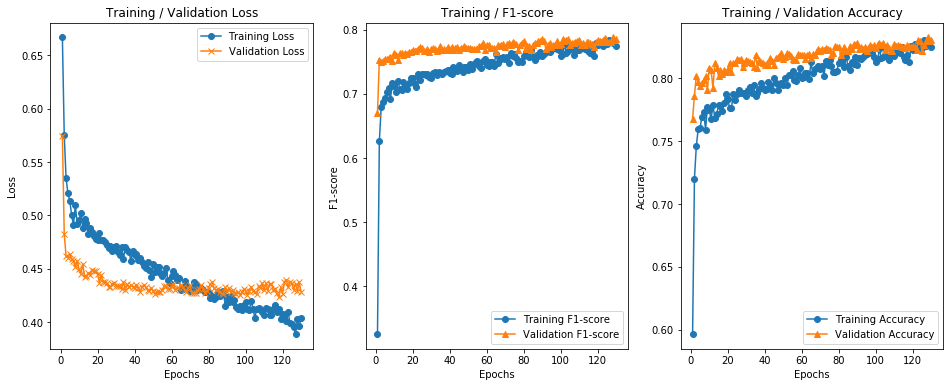

In [21]:
hist_dict = history.history

trg_loss = hist_dict['loss']
val_loss = hist_dict['val_loss']

trg_f1 = hist_dict['f1_m']
val_f1 = hist_dict['val_f1_m']

trg_acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']

epochs = range(1, len(trg_acc) + 1)

# plot losses and accuracies for training and validation 
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1, 3, 1)
plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
plt.title("Training / Validation Loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 3, 2)
plt.plot(epochs, trg_f1, marker='o', label='Training F1-score')
plt.plot(epochs, val_f1, marker='^', label='Validation F1-score')
plt.title("Training / F1-score")
ax.set_ylabel("F1-score")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

ax = fig.add_subplot(1, 3, 3)
plt.plot(epochs, trg_acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='^', label='Validation Accuracy')
plt.title("Training / Validation Accuracy")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epochs")
plt.legend(loc='best')

plt.show()

In [22]:
y_pred_lstm = LSTM_glove.predict(test_tweet_pad)
y_pred_lstm

array([[0.9052956 ],
       [0.6467035 ],
       [0.992288  ],
       ...,
       [0.94535226],
       [0.8681122 ],
       [0.45625374]], dtype=float32)

In [24]:
submission_lstm = pd.read_csv('data/sample_submission.csv')
submission_lstm["target"] = y_pred_lstm.round().astype('int')
submission_lstm.to_csv("max_len_50_5e-4_submission_new.csv", index=False)